In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from distance_and_fairness import *
from sklearn_extra.cluster import KMedoids
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


In [2]:
def submatrix (matrix, indexes):
    a = [[matrix[i][j] for i in indexes] for j in indexes]
    return a

def norm(matrix_a):
    mat_max, mat_min = matrix_a.max(), matrix_a.min()
    matrix_a = (matrix_a - mat_min)/(mat_max - mat_min)
    return matrix_a

def fairness_matrix(matrix_a, *attributes, ts_reduction="mean"):
    # calculate the conditional probs for every group 
    if (ts_reduction == "mean"):
        if matrix_a.mean(axis = 1) != 0:
            fair_array = attributes[0].mean(axis = 1)/matrix_a.mean(axis = 1)
        else: 
            fair_array.append(0)
    elif (ts_reduction == "last"):
        fair_array = []
        for i in range(0,len(matrix_a)):
            if matrix_a[i][-1] != 0:
                lst_ele = attributes[0][i][-1]/matrix_a[i][-1]
                fair_array.append(lst_ele)
            else: 
                fair_array.append(0)
    fair_array = np.array(fair_array)
    # make a fairness matrix (A_ij = |P_i - P_j|)
    fair_m = np.zeros((len(matrix_a),len(matrix_a)))
    for i in range(0, len(matrix_a)):
        for j in range(0, len(matrix_a)):
            fair_m[i][j] = abs(fair_array[i] - fair_array[j])
    return fair_m


def sts_matrix(matrix_a, time_period = 1):
    # calculate the sts matrix
    sts_m = zeros((len(matrix_a),len(matrix_a)))
    for i in range(0, len(matrix_a)):
        for j in range(0,len(matrix_a)):
            sts_sum = []
            for k in range(0,len(matrix_a[j])-1):
                # sts corresponds to the square root of the sum of the squared 
                # differences of the slopes obtained by considering time-series as linear 
                # functions between measurements
                sts_1 = (matrix_a[i][k+1] - matrix_a[i][k])/time_period
                sts_2 = (matrix_a[j][k+1] - matrix_a[j][k])/time_period
                sts = abs(sts_1 - sts_2)
                sts_sum.append(sts)
            sts_m[i][j] = sum(sts_sum)
    return sts_m


def distance(fairness_matrix, sts_matrix, a , normalize = True):
    # calculate distance d = sts + alpha * fairness

    if normalize == True: 
        fairness_matrix = norm(fairness_matrix)
        sts_matrix = norm(sts_matrix)
    
    else:
        fairness_matrix = np.multiply(a, fairness_matrix)
        distance_m = sts_matrix + fairness_matrix
        distance_m = norm(distance_m)
        
    return distance_m

In [3]:
def hirarchical_forecast (df, agg_level, disagg_level, aggregation_match):
    ''' method that performs hirarchical_forecast. 
    Parameters: df - dataframe that needs to be forecasted
                agg_level - list of aggregate columns
                disagg_level - list of disagg_level
                aggregation match - dictionary of matches of agg-disagg groups (e.g., )'''

    
    # add total column for df if it doesnt exist
    if 'total' not in df.columns:
        df['total'] = df[agg_level].sum(axis=1)

    # forecast for the aggregate groups - train set 20; test set 5
    pred_results = []
    for agg_cl in agg_level:
        train = df[agg_cl].iloc[0:-5]
        fit = Holt(train, initialization_method="heuristic").fit()
        pred = fit.forecast(5)
        df_pred = pd.DataFrame(pred)
        df_pred = df_pred.rename({0:agg_cl}, axis = 1)
        pred_results.append(df_pred)
    # merge the the aggregate groups together
    pred = pd.concat(pred_results, axis=1)
    
    # get the forecast of total
    pred['total'] = pred[agg_level].sum(axis=1)
    # top-down to forecast the disaggregate races
    for agg in agg_level:
        for disagg in aggregation_match[agg]:
            prop = df[disagg].mean()/df[agg].mean()
            pred[disagg] = prop*pred[agg]

    return pred 

    
def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

def submatrix (matrix, indexes):
    a = [[matrix[i][j] for i in indexes] for j in indexes]
    return a


In [4]:
def hirarchical_k_medoids(W,curr,size):
    '''function used to hirarchically cluster elements besed on the samilarity
        param: W - dissimilarity matrix, 2-D matrix
            curr - current cluster, 1-D list
            size - maximum numbers a cluster can have, an integer
    '''
    if (len(curr) <= size):
        return [curr]
    
    else: 
        W_sub = submatrix(W, curr)
        bisect_model = KMedoids(n_clusters=2, metric='precomputed', method='pam', init='random', random_state=0).fit(W_sub)
        lables = bisect_model.labels_
        indexes_set_0 = find_indices(lables, 0)
        indexes_set_1 = find_indices(lables, 1)
        cluster_0 = [curr[i] for i in indexes_set_0]
        cluster_1 = [curr[i] for i in indexes_set_1]
        return hirarchical_k_medoids(W,cluster_0,size) + hirarchical_k_medoids(W,cluster_1,size)

In [214]:



def draw_hirarchical_k_medoids(W,curr,size):
    '''function used to hirarchically cluster elements besed on the samilarity
        param: W - dissimilarity matrix, 2-D matrix
            curr - current cluster, 1-D list
            size - maximum numbers a cluster can have, an integer
    '''
    if (len(curr) <= size):
        return [curr]

    else: 
        W_sub = submatrix(W, curr)
        bisect_model = KMedoids(n_clusters=2, metric='precomputed', method='pam', init='random', random_state=0).fit(W_sub)
        lables = bisect_model.labels_
        indexes_set_0 = find_indices(lables, 0)
        indexes_set_1 = find_indices(lables, 1)

        cluster_0 = [curr[i] for i in indexes_set_0]
        cluster_1 = [curr[i] for i in indexes_set_1]
        result = hirarchical_k_medoids(W,cluster_0,size) + hirarchical_k_medoids(W,cluster_1,size)
        
        return result

In [216]:
# read data
df_enroll = pd.read_csv('C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_1/e_model_1.csv')
df_female = pd.read_csv('C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_1/f_model_1.csv')

cols = list(df_enroll.columns)
cols.remove('year')
array_enroll = df_enroll[cols]
array_female = df_female[cols]

array_enroll = array_enroll.T.values
array_female = array_female.T.values

# get the fairness matrix and the sts matrix
fair_m = fairness_matrix(array_enroll, array_female, ts_reduction="last")
fair_m = norm(fair_m)
sts_m = sts_matrix(array_enroll)


distance_m = distance(fair_m, sts_m, a = 0, normalize=False)
initial_c = list(range(0,len(distance_m)))
draw_hirarchical_k_medoids(distance_m, initial_c, 15)

[[67],
 [6, 9, 22, 23],
 [0, 2, 7, 8, 10, 11, 13, 15, 24, 34, 36, 39, 44, 68],
 [14],
 [16, 17, 30, 47],
 [4, 12, 21, 25, 28, 31, 32, 40, 41, 43, 46, 53, 58],
 [1],
 [19],
 [18],
 [33, 48, 49, 50, 51, 52, 56, 59, 60, 61, 62, 63, 64, 65, 66],
 [3, 20, 26, 27, 29, 35, 37, 42, 45, 54, 55, 57],
 [38],
 [5]]

In [237]:
# read data
df_enroll = pd.read_csv('C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_1/e_model_1.csv')
df_female = pd.read_csv('C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_1/f_model_1.csv')

cols = list(df_enroll.columns)
cols.remove('year')
array_enroll = df_enroll[cols]
array_female = df_female[cols]

array_enroll = array_enroll.T.values
array_female = array_female.T.values

# get the fairness matrix and the sts matrix
fair_m = fairness_matrix(array_enroll, array_female, ts_reduction="last")
fair_m = norm(fair_m)
sts_m = sts_matrix(array_enroll)

cluster_check = []
aggregation_matches = {}
clusters_number = []
for mu in range(0, 100000):

    distance_m = distance(fair_m, sts_m, a = mu, normalize=False)
    initial_c = list(range(0,len(distance_m)))
    # hirarchical clustering process
    s = hirarchical_k_medoids(distance_m, initial_c, 15)
    # make an list 
    c_lables = [0] * len(distance_m)

    for i in range(0,len(s)):
        for j in range(0,len(s[i])):
            index = s[i][j]
            c_lables[index] = i
    if (cluster_check != c_lables):        
        # record the number of clusters
        cluster_number = len(s)
        clusters_number.append(cluster_number)
    ############# to make datasets for model 3 ###############
        aggregation_match = {}
        agg_levels = []
        labels = array(c_lables)
        clusters = list(unique(labels))

        # make match of agrgegation
        for c in clusters: 
            indexes = find_indices(labels, c)
            agg_race_name = 'a_race_' + str(c)
            agg_levels.append(agg_race_name)
            disagg_race_set = []
            for i in indexes: 
                disagg_race_name = 'race_' + str(i)
                disagg_race_set.append(disagg_race_name)
            aggregation_match[agg_race_name] = disagg_race_set

        
        match = {w: k for k, v in aggregation_match.items() for w in v}
        df_enroll_model_3 = df_enroll.groupby(by=match,axis=1).sum() 
        df_enroll_model_3 = pd.concat([df_enroll_model_3, df_enroll], axis=1, join="inner")
        # make it time series
        index = pd.date_range(start="1995-01-01", end="2020", freq="A-Jan")
        df_enroll_model_3 = df_enroll_model_3.set_index(index)
        df_enroll_model_3 = df_enroll_model_3.drop('year', axis = 1)
        name_enroll = 'e_model_3_' + str(mu) + '.csv'
        # path_enroll = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/'+ name_enroll
        path_enroll = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/unfair/'+ name_enroll
        df_enroll_model_3.to_csv(path_enroll)
        
        df_female_model_3 =  df_female.groupby(by=match,axis=1).sum() 
        df_female_model_3 = pd.concat([df_female_model_3,  df_female], axis=1, join="inner")
        # make it time series
        index = pd.date_range(start="1995-01-01", end="2020", freq="A-Jan")
        df_female_model_3 = df_female_model_3.set_index(index)
        df_female_model_3 = df_female_model_3.drop('year', axis = 1)
        name_female = 'f_model_3_' + str(mu) + '.csv'
        # path_female = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/'+ name_female
        path_female = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/unfair/'+ name_female

        df_female_model_3.to_csv(path_female)
        
        str_mu = str(mu)
        aggregation_matches[mu] = aggregation_match
        cluster_check = c_lables


Forecast & evaluation

In [256]:
# Evaluation functions fore forecast accuracy

def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

def avg_mape(df_test, df_pred, columns):
    mapes = []
    for l in columns:
        test = df_test[l].iloc[-5:]
        pred = df_pred[l].iloc[-5:]
        mapp = mape(test, pred)
        mapes.append(mapp)
    avgmape = mean(mapes)
    return avgmape

def mapes(df_test, df_pred, columns):
    mapes = []
    for l in columns:
        test = df_test[l].iloc[-5:]
        pred = df_pred[l].iloc[-5:]
        mapp = mape(test, pred)
        mapes.append(mapp)
    return mapes

def wmape(y_test,pred):
    y_test, pred = np.array(y_test), np.array(pred)
    deno = np.abs(y_test).sum()
    num = np.abs(y_test - pred).sum()
    if deno != 0:
        wmape = num/deno
    else:
        wmape = 0
    return wmape

def avg_wmape(df_test, df_pred, columns):
    wmapes = []
    for l in columns:
        test = df_test[l].iloc[-5:]
        pred = df_pred[l].iloc[-5:]
        wmap = wmape(test, pred)
        wmapes.append(wmap)
    avgwmape = mean(wmapes)
    return avgwmape

def wmapes(df_test, df_pred, columns):
    wmapes = []
    for l in columns:
        test = df_test[l].iloc[-5:]
        pred = df_pred[l].iloc[-5:]
        wmap = wmape(test, pred)
        wmapes.append(wmap)
    return wmapes

def diff_accuracy(df_test, df_pred, columns, metric):
    if metric ==  'wmapes':
        lst = wmapes(df_test, df_pred, columns)
    elif metric == 'mapes':
        lst = mapes(df_test, df_pred, columns)
    
    # create a list to store the diffrences of accuracys 
    diff_accs = []
    combs = list(itertools.combinations(lst, 2))
    for x in combs:
        diff = abs(x[1] - x[0])
        diff_accs.append(diff)
        
    diff_acc = mean(diff_accs)
    return diff_acc

##### forecast for model 1

In [233]:
df_enroll_m1 = pd.read_csv('C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_1/e_model_1.csv')
disagg_level = [c for c in df_enroll_m1.columns if c.count('_') == 1] 

# get the total value
df_enroll_m1['total'] = df_enroll_m1[disagg_level].sum(axis=1)
# forcast for total
pred_results = []

# forecasts for disaggregate level
for disagg_cl in disagg_level:
    train = df_enroll_m1[disagg_cl].iloc[0:-5]
    fit = Holt(train, initialization_method="heuristic").fit()
    pred = fit.forecast(5)
    df_pred = pd.DataFrame(pred)
    df_pred = df_pred.rename({0:disagg_cl}, axis = 1)
    pred_results.append(df_pred)

# forecasts for total level
train = df_enroll_m1['total'].iloc[0:-5]
fit =  Holt(train, initialization_method="heuristic").fit()
pred = fit.forecast(5)
df_pred = pd.DataFrame(pred)
df_pred = df_pred.rename({0:'total'}, axis = 1)
pred_results.append(df_pred)
pred_m_1 = pd.concat(pred_results, axis=1)


# evaluation
total_test = df_enroll_m1['total'].iloc[-5:]
total_pred = pred_m_1['total'].iloc[-5:]
print("mape at total level: " , mape(total_test, total_pred))

print('wmape at disagg level', avg_wmape(df_enroll_m1, pred_m_1, disagg_level))

df_enroll_m1_wmapes = wmapes(df_enroll_m1, pred_m_1, disagg_level)


mape at total level:  0.02743564023007523
wmape at disagg level 0.08290806535742655


##### forecast for model 2

In [230]:
aggregation_match_m_2 = {'a_race_0': ['race_0',
  'race_1',
  'race_2',
  'race_3'],
 'a_race_1': ['race_4',
  'race_5',
  'race_6',
  'race_7',
  'race_8'],
 'a_race_2': ['race_9'],
 'a_race_4': ['race_10',
  'race_11',
  'race_12',
  'race_13',
  'race_14',
  'race_15',
  'race_16',
  'race_17',
  'race_18',
  'race_19',
  'race_20',
  'race_21',
  'race_22',
  'race_23',
  'race_24',
  'race_25',
  'race_26'],
 'a_race_3': ['race_27',
  'race_28',
  'race_29',
  'race_30',
  'race_31',
  'race_32',
  'race_33'],
 'a_race_5': ['race_34',
  'race_35',
  'race_36',
  'race_37',
  'race_38',
  'race_39',
  'race_40',
  'race_41',
  'race_42',
  'race_43',
  'race_44',
  'race_45',
  'race_46',
  'race_47',
  'race_48',
  'race_49',
  'race_50',
  'race_51',
  'race_52',
  'race_53',
  'race_54',
  'race_55',
  'race_56',
  'race_57',
  'race_58',
  'race_59',
  'race_60',
  'race_61',
  'race_62',
  'race_63',
  'race_64',
  'race_65',
  'race_66'],
 'a_race_6': ['race_67', 'race_68']}

In [234]:

df_enroll_m2 = pd.read_csv('C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_2/e_model_2.csv')
disagg_level = [c for c in df_enroll_m2.columns if c.count('_') == 1] 
agg_level = [c for c in df_enroll_m2.columns if c.count('_') == 2] 

pred_m_2 = hirarchical_forecast(df_enroll_m2, agg_level, disagg_level, aggregation_match_m_2)

# get the total value for test set
df_enroll_m2['total'] = df_enroll_m2[disagg_level].sum(axis=1)

# evaluation
total_test = df_enroll_m2['total'].iloc[-5:]
total_pred = pred_m_2['total'].iloc[-5:]
print("mape at total level: " , mape(total_test, total_pred))
print("mape at aggre level: " , avg_mape(df_enroll_m2, pred_m_2, agg_level))

print('wmape at disagg level', avg_wmape(df_enroll_m2, pred_m_2, disagg_level))
df_enroll_m2_wmapes = wmapes(df_enroll_m2, pred_m_2, disagg_level)
df_enroll_m2_mapes = mapes(df_enroll_m2, pred_m_2, agg_level)

mape at total level:  0.025687924713504433
mape at aggre level:  0.023028016395159685
wmape at disagg level 0.07881867333748031


##### forecast for model 3 (mu = 0)

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [240]:
mu = 0
# file_name = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/e_model_3_' + str(mu) + ".csv"
file_name = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/unfair/e_model_3_' + str(mu) + ".csv"

df_enroll_m3 = pd.read_csv(file_name, index_col=[0])
disagg_level = [c for c in df_enroll_m3.columns if c.count('_') == 1] 
agg_level = [c for c in df_enroll_m3.columns if c.count('_') == 2] 
aggregation_match_m_3 = aggregation_matches[mu]
pred_m_3 = hirarchical_forecast(df_enroll_m3, agg_level, disagg_level, aggregation_match_m_3)

# get the total value for test set
df_enroll_m3['total'] = df_enroll_m3[disagg_level].sum(axis=1)

# evaluation
total_test = df_enroll_m3['total'].iloc[-5:]
total_pred = pred_m_3['total'].iloc[-5:]
print("mape at total level: " , mape(total_test, total_pred))
print("mape at aggre level: " , avg_mape(df_enroll_m3, pred_m_3, agg_level))
print('wmape at disagg level', avg_wmape(df_enroll_m3, pred_m_3, disagg_level))

df_enroll_m3_wmapes_0 = wmapes(df_enroll_m3, pred_m_3, disagg_level)
df_enroll_m3_mapes_0 = mapes(df_enroll_m3, pred_m_3, agg_level)


mape at total level:  0.026342856630864348
mape at aggre level:  0.03058068926920942
wmape at disagg level 0.0799952640056141


In [238]:
mu = 63577
# file_name = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/e_model_3_' + str(mu) + ".csv"
file_name = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/unfair/e_model_3_' + str(mu) + ".csv"

df_enroll_m3 = pd.read_csv(file_name, index_col=[0])
disagg_level = [c for c in df_enroll_m3.columns if c.count('_') == 1] 
agg_level = [c for c in df_enroll_m3.columns if c.count('_') == 2] 
aggregation_match_m_3 = aggregation_matches[mu]
pred_m_3 = hirarchical_forecast(df_enroll_m3, agg_level, disagg_level, aggregation_match_m_3)

# get the total value for test set
df_enroll_m3['total'] = df_enroll_m3[disagg_level].sum(axis=1)

# evaluation
total_test = df_enroll_m3['total'].iloc[-5:]
total_pred = pred_m_3['total'].iloc[-5:]
print("mape at total level: " , mape(total_test, total_pred))
print("mape at aggre level: " , avg_mape(df_enroll_m3, pred_m_3, agg_level))
print('wmape at disagg level', avg_wmape(df_enroll_m3, pred_m_3, disagg_level))

df_enroll_m3_wmapes_63577 = wmapes(df_enroll_m3, pred_m_3, disagg_level)
df_enroll_m3_mapes_63577 = mapes(df_enroll_m3, pred_m_3, agg_level)

mape at total level:  0.026548338836984115
mape at aggre level:  0.08411847349564304
wmape at disagg level 0.08097576308778753


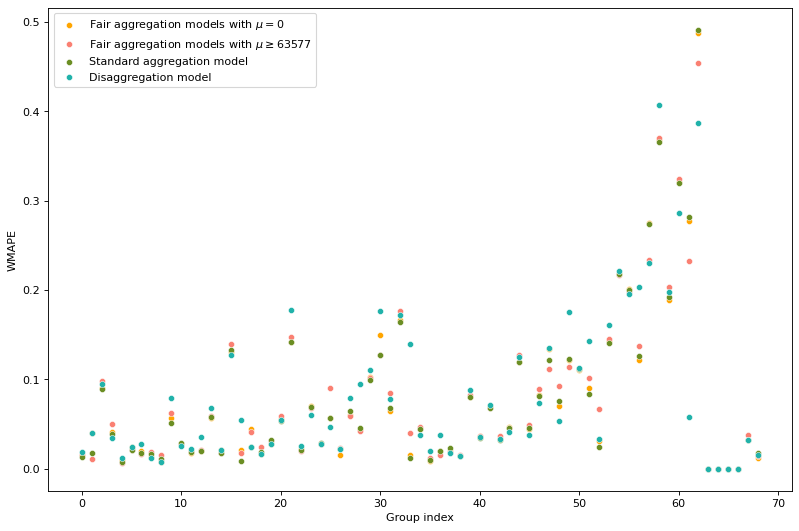

In [249]:
index = []
for i in range(0,len(df_enroll_m3_wmapes)):
    index.append(i)

plt.figure(figsize=(12, 8), dpi=80)


graph = sns.scatterplot(index, df_enroll_m3_wmapes_0, ci=None, color='orange', marker = 'o', label = 'Fair aggregation models with ' + r'$\mu = 0$',s=30)
sns.scatterplot(index, df_enroll_m3_wmapes_63577, ci=None, color='salmon', marker = 'o', label = 'Fair aggregation models with ' + r'$\mu \geq 63577$',s=30)

sns.scatterplot(index, df_enroll_m2_wmapes, ci=None, color='olivedrab', marker = 'o',  label = 'Standard aggregation model',s=30)
sns.scatterplot(index, df_enroll_m1_wmapes, ci=None, color='lightseagreen', marker = 'o', label = 'Disaggregation model',s=30)

# graph.axhline(0.027, color='lightblue')
# graph.axhline(0.083, color='lightblue', label = 'Disaggregation model')

# graph.axhline(0.079, color='lightpink')
# graph.axhline(0.051, color='lightpink')
# graph.axhline(0.026, color='lightpink', label = 'standard aggregation model')


plt.xlabel('Group index')
plt.ylabel('WMAPE')
graph.legend(loc = 'best')


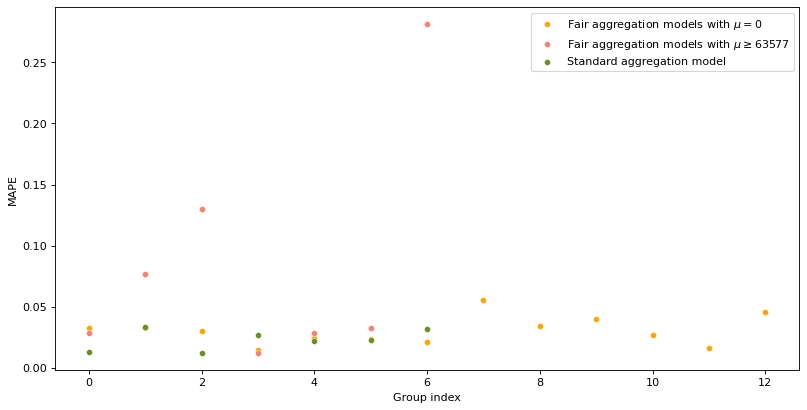

In [251]:
plt.figure(figsize=(12, 6), dpi=80)

index = []
for i in range(0,len(df_enroll_m3_mapes_0)):
    index.append(i)
    
graph = sns.scatterplot(index, df_enroll_m3_mapes_0, ci=None, color='orange', marker = 'o', label = 'Fair aggregation models with ' + r'$\mu = 0$',s=30)

index = []
for i in range(0,len(df_enroll_m3_mapes_63577)):
    index.append(i)
sns.scatterplot(index, df_enroll_m3_mapes_63577, ci=None, color='salmon', marker = 'o', label = 'Fair aggregation models with ' + r'$\mu \geq 63577$',s=30)
index = []
for i in range(0,len(df_enroll_m2_mapes)):
    index.append(i)
sns.scatterplot(index, df_enroll_m2_mapes, ci=None, color='olivedrab', marker = 'o',  label = 'Standard aggregation model',s=30)

# graph.axhline(0.027, color='lightblue')
# graph.axhline(0.083, color='lightblue', label = 'Disaggregation model')

# graph.axhline(0.079, color='lightpink')
# graph.axhline(0.051, color='lightpink')
# graph.axhline(0.026, color='lightpink', label = 'standard aggregation model')


plt.xlabel('Group index')
plt.ylabel('MAPE')
graph.legend(loc = 'best')


In [631]:
mu = 63580
#file_name = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/e_model_3_' + str(mu) + ".csv"
file_name = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/unfair/e_model_3_' + str(mu) + ".csv"

df_enroll_m3 = pd.read_csv(file_name, index_col=[0])
disagg_level = [c for c in df_enroll_m3.columns if c.count('_') == 1] 
agg_level = [c for c in df_enroll_m3.columns if c.count('_') == 2] 
aggregation_match_m_3 = aggregation_matches[mu]
pred_m_3 = hirarchical_forecast(df_enroll_m3, agg_level, disagg_level, aggregation_match_m_3)

# get the total value for test set
df_enroll_m3['total'] = df_enroll_m3[disagg_level].sum(axis=1)

# evaluation
total_test = df_enroll_m3['total'].iloc[-5:]
total_pred = pred_m_3['total'].iloc[-5:]
print("mape at total level: " , mape(total_test, total_pred))
print("mape at aggre level: " , avg_mape(df_enroll_m3, pred_m_3, agg_level))
print('wmape at disagg level', avg_wmape(df_enroll_m3, pred_m_3, disagg_level))

mape at total level:  0.026548338836984115
mape at aggre level:  0.08411847349564304
wmape at disagg level 0.08097576308778753


In [270]:
diff_accuracy(df_enroll_m2, pred_m_2, agg_level, 'mapes')


0.01024642003855045

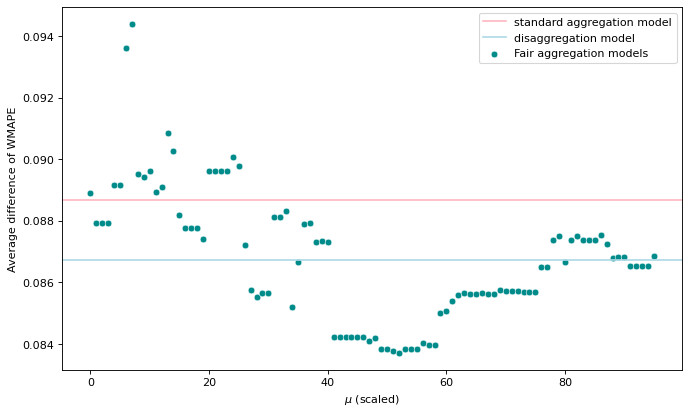

In [268]:
diff_accuracys = []
mus = []
for mu in aggregation_matches:
    mus.append(mu)
    file_name = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/unfair/e_model_3_' + str(mu) + ".csv"
    df_enroll_m3 = pd.read_csv(file_name, index_col=[0])
    disagg_level = [c for c in df_enroll_m3.columns if c.count('_') == 1] 
    agg_level = [c for c in df_enroll_m3.columns if c.count('_') == 2] 
    aggregation_match_m_3 = aggregation_matches[mu]
    pred_m_3 = hirarchical_forecast(df_enroll_m3, agg_level, disagg_level, aggregation_match_m_3)
    acc = diff_accuracy(df_enroll_m3, pred_m_3, disagg_level, 'wmapes')
    diff_accuracys.append(acc)

index = []
for i in (range(0,len(mus))):
    index.append(i)

    
plt.figure(figsize=(10,6), dpi=80)

g = sns.scatterplot(index, diff_accuracys, ci=None, color='darkcyan', marker = 'o', label = 'Fair aggregation models')
g.axhline(0.08868399010900163, color='lightpink', label = 'standard aggregation model')
g.axhline(0.08671812258547734, color='lightblue', label = 'disaggregation model')

plt.xlabel(r'$\mu$' + ' (scaled)')
plt.ylabel('Average difference of WMAPE')
plt.legend()

In [ ]:
diff_accuracys = []
mus = []
for mu in aggregation_matches:
    mus.append(mu)
    file_name = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/unfair/e_model_3_' + str(mu) + ".csv"
    df_enroll_m3 = pd.read_csv(file_name, index_col=[0])
    disagg_level = [c for c in df_enroll_m3.columns if c.count('_') == 1] 
    agg_level = [c for c in df_enroll_m3.columns if c.count('_') == 2] 
    aggregation_match_m_3 = aggregation_matches[mu]
    pred_m_3 = hirarchical_forecast(df_enroll_m3, agg_level, disagg_level, aggregation_match_m_3)
    acc = diff_accuracy(df_enroll_m3, pred_m_3, agg_level, 'mapes')
    diff_accuracys.append(acc)

index = []
for i in (range(0,len(mus))):
    index.append(i)

    
plt.figure(figsize=(10,6), dpi=80)

g = sns.scatterplot(index, diff_accuracys, ci=None, color='darkcyan', marker = 'o', label = 'Fair aggregation models')
g.axhline(0.01024642003855045, color='lightpink', label = 'standard aggregation model')

plt.xlabel(r'$\mu$' + ' (scaled)')
plt.ylabel('Average difference of MAPE')
plt.legend()

In [219]:
mus = []
mapes = []
avg_mapes = []
avg_wmapes = []
for mu in aggregation_matches:
    mus.append(mu)
    # file_name = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/e_model_3_' + str(mu) + ".csv"
    file_name = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/unfair/e_model_3_' + str(mu) + ".csv"
    df_enroll_m3 = pd.read_csv(file_name, index_col=[0])
    disagg_level = [c for c in df_enroll_m3.columns if c.count('_') == 1] 
    agg_level = [c for c in df_enroll_m3.columns if c.count('_') == 2] 
    aggregation_match_m_3 = aggregation_matches[mu]
    pred_m_3 = hirarchical_forecast(df_enroll_m3, agg_level, disagg_level, aggregation_match_m_3)

    # get the total value for test set
    df_enroll_m3['total'] = df_enroll_m3[disagg_level].sum(axis=1)

    # evaluation
    total_test = df_enroll_m3['total'].iloc[-5:]
    total_pred = pred_m_3['total'].iloc[-5:]
    mapes.append(mape(total_test, total_pred))
    avg_mapes.append(avg_mape(df_enroll_m3, pred_m_3, agg_level))
    avg_wmapes.append(avg_wmape(df_enroll_m3, pred_m_3, disagg_level))


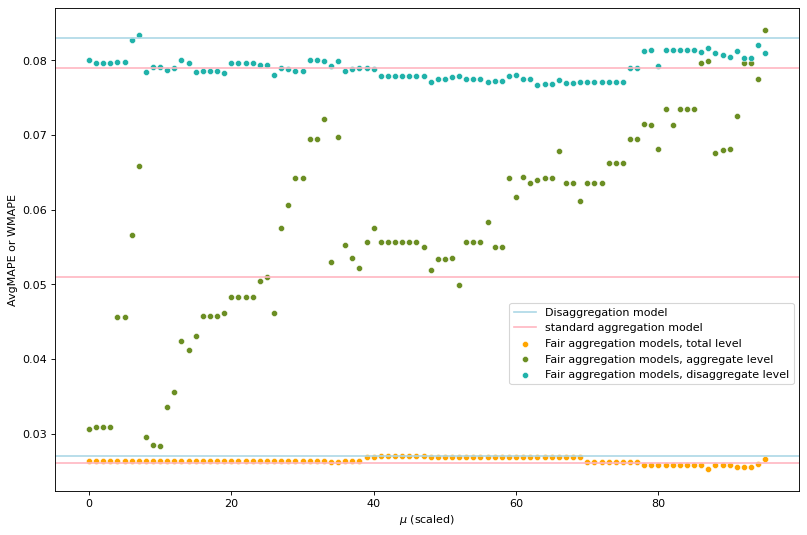

In [139]:
index = []
for i in range(0,len(mus)):
    index.append(i)

plt.figure(figsize=(12, 8), dpi=80)


graph = sns.scatterplot(index, mapes, ci=None, color='orange', marker = 'o', label = 'Fair aggregation models, total level',s=30)

sns.scatterplot(index, avg_mapes, ci=None, color='olivedrab', marker = 'o',  label = 'Fair aggregation models, aggregate level',s=30)
sns.scatterplot(index, avg_wmapes, ci=None, color='lightseagreen', marker = 'o', label = 'Fair aggregation models, disaggregate level',s=30)

graph.axhline(0.027, color='lightblue')
graph.axhline(0.083, color='lightblue', label = 'Disaggregation model')

graph.axhline(0.079, color='lightpink')
graph.axhline(0.051, color='lightpink')
graph.axhline(0.026, color='lightpink', label = 'standard aggregation model')


plt.xlabel(r'$\mu$' + ' (scaled)')
plt.ylabel('AvgMAPE or WMAPE')
graph.legend(loc = 'best',bbox_to_anchor=(1,0.4))


fairness evaluation

In [10]:
def permutation(df, columns):
    perm_lst = []
    column_name_lst = []
    
    perms = list(itertools.combinations(columns, 2))
    for p in perms: 
        col1 = df[p[0]]
        col2 = df[p[1]]
        perm_lst.append([col1, col2])
        column_name_lst.append([p[0],p[1]])
    return column_name_lst, perm_lst

def stat_disparity(x_1, x_2, a_1, a_2, method = 'last'):
    '''function to calculate the statistical disparity
        params: x_1, x_2: two arrays - timeseries; a_1, a_2: corresponding attributes
        return: 
    '''
    if method == 'mean':
        sd = abs(a_1.mean()/x_1.mean() - a_1.mean()/x_1.mean())
    elif method == 'last':
        sd_array = abs(a_1/x_1 - a_2/x_2)
        sd = sd_array[-1]
    elif method == 'complete_serie':
        sd = abs(a_1/x_1 - a_2/x_2)
    return sd

def avg_stat_parity (df, df_attribute, columns, method = 'last'):
    column_name_lst, perm_lst = permutation(df, columns)
    sd_lst = []
    for col_pair in column_name_lst:
        x_1 = array(df[col_pair[0]])
        x_2 = array(df[col_pair[1]])
        a_1 = array(df_attribute[col_pair[0]])
        a_2 = array(df_attribute[col_pair[1]])
        
        if method == 'last' or method == 'mean':
            sd = stat_disparity(x_1, x_2, a_1, a_2, method = 'last')
            sd_lst.append(sd)
    avg_sd = sum(sd_lst)/len(column_name_lst)
    return avg_sd    

For model 2

In [693]:
df_enroll_m2 = pd.read_csv('C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_2/e_model_2.csv')
df_female_m2 = pd.read_csv('C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_2/f_model_2.csv')
agg_level = [c for c in df_enroll_m2.columns if c.count('_') == 2] 
disagg_level = [c for c in df_enroll_m2.columns if c.count('_') == 1] 
print(avg_stat_parity(df_enroll_m2, df_female_m2, agg_level, method = 'last'))


0.044194128375415774


for model 3

In [135]:
mu = 0
# file_name_enroll = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/e_model_3_' + str(mu) + ".csv"
# file_name_female = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/f_model_3_' + str(mu) + ".csv"

file_name_enroll = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/unfair/e_model_3_' + str(mu) + ".csv"
file_name_female = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/unfair/f_model_3_' + str(mu) + ".csv"

df_enroll_m3 = pd.read_csv(file_name_enroll, index_col=[0])
df_female_m3 = pd.read_csv(file_name_female, index_col=[0])
agg_level = [c for c in df_enroll_m3.columns if c.count('_') == 2] 
avg_stat_parity(df_enroll_m3, df_female_m3, agg_level, method = 'last')

0.053610957106264095

In [136]:
avg_stat_parity(df_enroll_m3, df_female_m3, agg_level, method = 'last')

0.053610957106264095

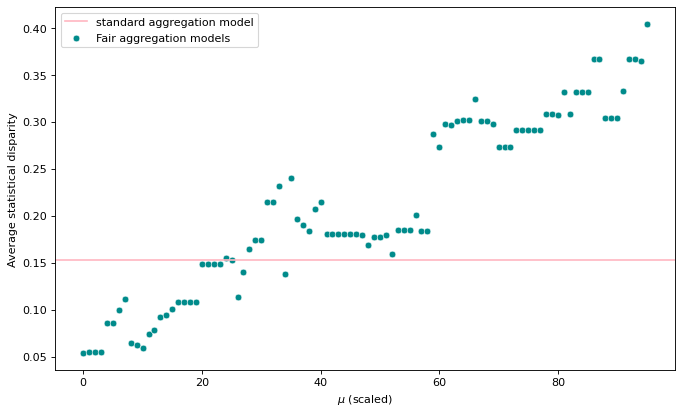

In [140]:
mus = []
avgsps = []
avgsps_fair = []

for mu in aggregation_matches:
    mus.append(mu)
    file_name_enroll = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/unfair/e_model_3_' + str(mu) + ".csv"
    file_name_female = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/unfair/f_model_3_' + str(mu) + ".csv"

    df_enroll_m3 = pd.read_csv(file_name_enroll, index_col=[0])
    df_female_m3 = pd.read_csv(file_name_female, index_col=[0])
    
    disagg_level = [c for c in df_enroll_m3.columns if c.count('_') == 1] 
    agg_level = [c for c in df_enroll_m3.columns if c.count('_') == 2] 
    
    aggregation_match_m_3 = aggregation_matches[mu]
    sp = avg_stat_parity(df_enroll_m3, df_female_m3, agg_level, method = 'last')
    avgsps.append(sp)

index = []
for i in (range(0,len(mus))):
    index.append(i)
    
       
# mus_fair = []
# for mu in aggregation_matches_fair:
#     mus_fair.append(mu)
#     file_name_enroll = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/e_model_3_' + str(mu) + ".csv"
#     file_name_female = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/f_model_3_' + str(mu) + ".csv"

#     df_enroll_m3 = pd.read_csv(file_name_enroll, index_col=[0])
#     df_female_m3 = pd.read_csv(file_name_female, index_col=[0])
    
#     disagg_level = [c for c in df_enroll_m3.columns if c.count('_') == 1] 
#     agg_level = [c for c in df_enroll_m3.columns if c.count('_') == 2] 
    
#     aggregation_match_m_3 = aggregation_matches_fair[mu]
#     sp = avg_stat_parity(df_enroll_m3, df_female_m3, agg_level, method = 'last')
#     avgsps_fair.append(sp)
    
# index_fair = []


# for i in (range(0,len(mus_fair))):
#     index_fair.append(i)
    
plt.figure(figsize=(10,6), dpi=80)

g = sns.scatterplot(index, avgsps, ci=None, color='darkcyan', marker = 'o', label = 'Fair aggregation models')
g.axhline(0.153, color='lightpink', label = 'standard aggregation model')

plt.xlabel(r'$\mu$' + ' (scaled)')
plt.ylabel('Average statistical disparity')
plt.legend()


Text(0, 0.5, 'Average statistical disparity between aggregate groups')

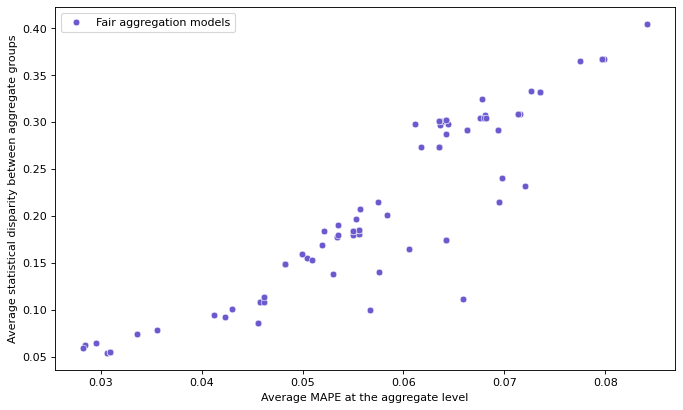

In [218]:
mus = []
avgsps = []
avgsps_fair = []

for mu in aggregation_matches:
    mus.append(mu)
    file_name_enroll = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/unfair/e_model_3_' + str(mu) + ".csv"
    file_name_female = 'C:/Users/Shuyu/Documents/research/OneDrive/research/Forecasting Paper/Data/enrollment_gender/model_3/unfair/f_model_3_' + str(mu) + ".csv"

    df_enroll_m3 = pd.read_csv(file_name_enroll, index_col=[0])
    df_female_m3 = pd.read_csv(file_name_female, index_col=[0])
    
    disagg_level = [c for c in df_enroll_m3.columns if c.count('_') == 1] 
    agg_level = [c for c in df_enroll_m3.columns if c.count('_') == 2] 
    
    aggregation_match_m_3 = aggregation_matches[mu]
    if mu <=0 :
        sp = avg_stat_parity(df_enroll_m3, df_female_m3, agg_level, method = 'mean')
    else: 
        sp = avg_stat_parity(df_enroll_m3, df_female_m3, agg_level, method = 'last')
    avgsps.append(sp)

index = []
for i in (range(-len(mus),len(mus),2)):
    index.append(i)
    
plt.figure(figsize=(10,6), dpi=80)

sns.scatterplot(avg_mapes, avgsps, ci=None, color='slateblue', marker = 'o' , label = 'Fair aggregation models')



plt.xlabel('Average MAPE at the aggregate level')
plt.ylabel('Average statistical disparity between aggregate groups')

clustering

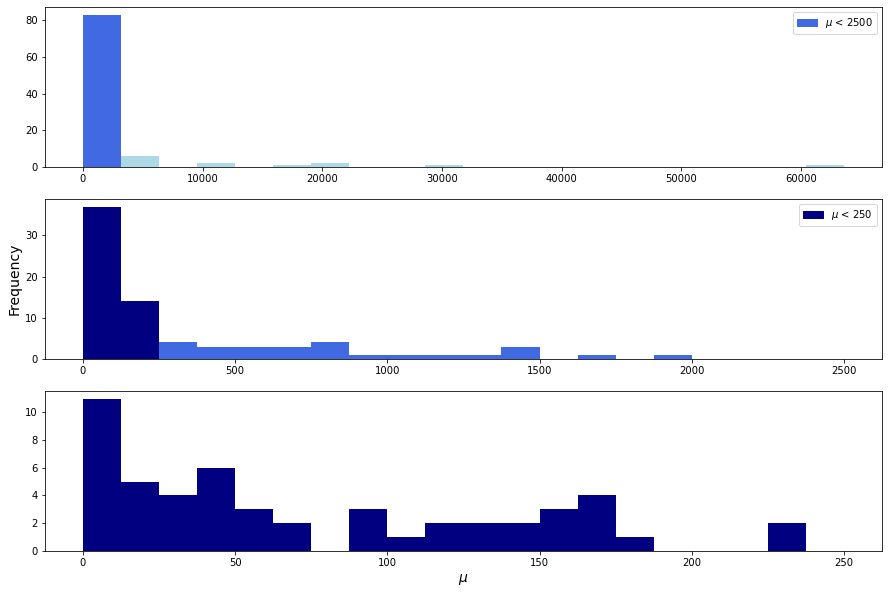

In [123]:
import matplotlib.patches as mpatches

figure, axis = plt.subplots(3, 1, figsize=(15, 10))
N, bins, patches = axis[0].hist(mus, bins=20, color='lightblue')
for i in range(0,1):
    patches[i].set_facecolor('royalblue')

N, bins, patches = axis[1].hist(mus, range = [0,2500],bins=20, color='royalblue')
for i in range(0,2):
    patches[i].set_facecolor('navy')
    
axis[2].hist(mus, range = [0,250],bins=20, color='navy')
plt.xlabel(r'$\mu$' , fontsize=14)
axis[1].set_ylabel('Frequency', fontsize=14)

red_patch = mpatches.Patch(color='royalblue', label= r'$\mu$ < 2500')
axis[0].legend(handles=[red_patch])

red_patch = mpatches.Patch(color='navy', label= r'$\mu$ < 250')
axis[1].legend(handles=[red_patch])


In [50]:
np.arange(min(mus), max(mus)+1)

array([    0,     1,     2, ..., 63575, 63576, 63577])

Text(0, 0.5, 'Number of clusters')

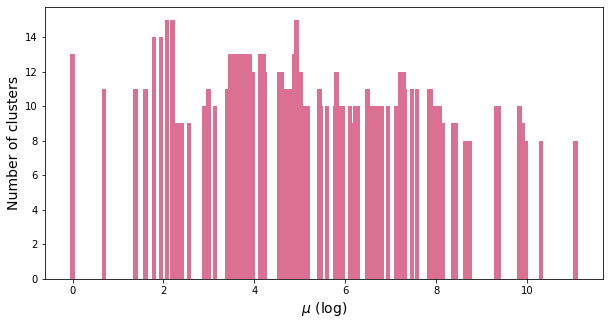

In [119]:
fig = plt.figure(figsize = (10, 5))
clusters_number_1 = clusters_number[:-1]
mus_log = [log(x) for x in mus if x > 0]
plt.bar(mus_log, clusters_number_1, color ='palevioletred', width = 0.1)
plt.xlabel(r'$\mu$ (log)'  , fontsize=14)
plt.ylabel("Number of clusters"  , fontsize=14)

In [120]:
mus_log

[0.0,
 0.6931471805599453,
 1.3862943611198906,
 1.6094379124341003,
 1.791759469228055,
 1.9459101490553132,
 2.0794415416798357,
 2.1972245773362196,
 2.302585092994046,
 2.3978952727983707,
 2.5649493574615367,
 2.8903717578961645,
 2.9444389791664403,
 2.995732273553991,
 3.1354942159291497,
 3.4011973816621555,
 3.4657359027997265,
 3.5553480614894135,
 3.58351893845611,
 3.6635616461296463,
 3.6888794541139363,
 3.8066624897703196,
 3.828641396489095,
 3.871201010907891,
 3.8918202981106265,
 3.912023005428146,
 3.970291913552122,
 4.127134385045092,
 4.204692619390966,
 4.23410650459726,
 4.553876891600541,
 4.564348191467836,
 4.59511985013459,
 4.700480365792417,
 4.795790545596741,
 4.812184355372417,
 4.867534450455582,
 4.912654885736052,
 4.927253685157205,
 4.9344739331306915,
 5.017279836814924,
 5.0369526024136295,
 5.062595033026967,
 5.093750200806762,
 5.10594547390058,
 5.14166355650266,
 5.159055299214529,
 5.1647859739235145,
 5.438079308923196,
 5.463831805025610